In [11]:
import arviz as az
import chi
import matplotlib.pyplot as plt
import numpy as np
import pints
import scipy.stats
import seaborn as sns
sns.set_theme()

# 100 Individuals with 10 measurements each

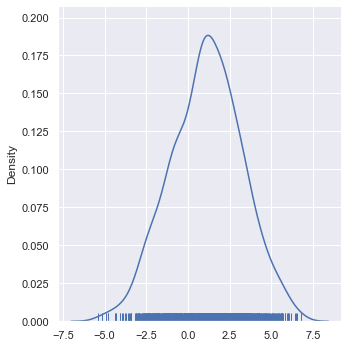

In [166]:
np.random.seed(42)
n_ids = 100
n_samples_per_id = 10
true_parameters = [1.3, 2.12, 1]  # pop mean, pop std., noise
means = np.random.normal(
    loc=true_parameters[0], scale=true_parameters[1], size=n_ids)
data = np.empty(shape=(n_ids, n_samples_per_id))
for ids, mean in enumerate(means):
    data[ids] = np.random.normal(
    loc=mean, scale=true_parameters[2], size=n_samples_per_id)

sns.displot(data.flatten(), kind='kde', rug=True)
plt.show()

In [163]:
class ExactHierarchicalLogLikelihood(chi.LogLikelihood):
    def __init__(self, observations):
        self._observations = observations
        self._n_ids, self._n_obs = observations.shape
        self._error_model = chi.GaussianErrorModel()
        self._pop_model = chi.GaussianModel()

    def __call__(self, parameters):
        # Compute population contribution
        means = parameters[:self._n_ids]
        pop_mean, pop_sigma, sigma = parameters[self._n_ids:]
        score = np.sum(
            scipy.stats.norm(loc=pop_mean, scale=pop_sigma).logpdf(
                means))
        if np.isinf(score):
            return score

        # Compute contributions from individual log-likelihoods
        for _id, mean in enumerate(means):
            score += np.sum(
            scipy.stats.norm(loc=mean, scale=sigma).logpdf(
                self._observations[_id]))

        return score

    def evaluateS1(self, parameters):
        # Compute population contribution
        means = np.array(parameters[:self._n_ids])
        pop_mean, pop_sigma, sigma = parameters[self._n_ids:]
        score, pop_sens = self._pop_model.compute_sensitivities(
            parameters=[pop_mean, pop_sigma], observations=means)

        # Compute individual contributions
        sensitivities = np.zeros(self.n_parameters())
        for _id, indiv_obs in enumerate(self._observations):
            s, sens = self._error_model.compute_sensitivities(
                parameters=[sigma],
                model_output=np.array([means[_id]] * self._n_obs),
                model_sensitivities=np.ones(shape=(self._n_obs, 1)),
                observations=indiv_obs)

            score += s
            sensitivities[_id] += sens[0]
            sensitivities[-1] += sens[-1]

        # Add population sensitivities
        sensitivities[:-1] += pop_sens

        return score, sensitivities

    def n_parameters(self):
        return self._n_ids + 3

    def get_parameter_names(self):
        return ['Mean'] * self._n_ids + [
            'Pop. mean', 'Pop. std.', 'Pooled Sigma']

    def get_id(self):
        return ['ID %d' % _id for _id in range(self._n_ids)] + [None] * 3


class GaussianKDELogLikelihood(chi.LogLikelihood):
    def __init__(self, observations, n_ids=10, n_samples=10):
        self._observations = np.array(observations).flatten()
        self._n_ids = int(n_ids)
        self._n_samples = int(n_samples)
        self._n_measurements = self._n_ids * self._n_samples
        self._normal = chi.GaussianErrorModel()

    def __call__(self, parameters):
        standard_mean_samples = np.array(parameters[:self._n_ids])
        standard_noise_samples = np.array(parameters[
            self._n_ids:self._n_ids+self._n_measurements]).reshape(
                (self._n_ids, self._n_samples))
        pop_mean, pop_std, sigma = parameters[-3:]

        # Compute measurements
        mean_samples = pop_mean + standard_mean_samples * pop_std
        measurements = \
            mean_samples[:, np.newaxis] + sigma * standard_noise_samples

        # Estimate population mean and population std from samples
        pop_mu = np.mean(measurements)
        pop_sigma = np.std(measurements, ddof=1)
        score = np.sum(
            scipy.stats.norm(loc=pop_mu, scale=pop_sigma).logpdf(
                self._observations))

        if np.isnan(score):
            return -np.inf

        return score

    def evaluateS1(self, parameters):
        # Eta are inter-individual fluctuations and epsilon are measurement
        # fluctuations
        eta = np.array(parameters[:self._n_ids])
        epsilon = np.array(parameters[
            self._n_ids:self._n_ids+self._n_measurements]).reshape(
                (self._n_ids, self._n_samples))
        pop_mu, pop_sigma, sigma = parameters[-3:]

        # Compute measurements
        mean_samples = pop_mu + eta * pop_sigma
        measurements = \
            mean_samples[:, np.newaxis] + sigma * epsilon

        # Estimate population mean and population std from samples
        pop_mu_hat = np.mean(measurements)
        pop_sigma_hat = np.std(measurements, ddof=1)

        # Compute sensitivities of pop_mu and pop_sigma to parameters
        dpop_mu_hat_deta = pop_sigma / self._n_ids
        dpop_mu_hat_depsilon = sigma / self._n_measurements
        dpop_mu_hat_dpop_mu = 1
        dpop_mu_hat_dpop_sigma = np.mean(eta)
        dpop_mu_hat_dsigma = np.mean(epsilon)
        dpop_sigma_hat_deta = pop_sigma * np.sum(
            measurements - pop_mu_hat, axis=1) / (self._n_measurements - 1) / \
            pop_sigma_hat
        dpop_sigma_hat_depsilon = (
            sigma * (measurements - pop_mu_hat) / (self._n_measurements - 1) /
            pop_sigma_hat).reshape(self._n_measurements)
        dpop_sigma_hat_dpop_mu = 0
        dpop_sigma_hat_dpop_sigma = np.sum((measurements - pop_mu_hat) *
            eta[:, np.newaxis]) / (self._n_measurements - 1) / pop_sigma_hat
        dpop_sigma_hat_dsigma = np.sum((measurements - pop_mu_hat) * epsilon
            ) / (self._n_measurements - 1) / pop_sigma_hat

        # Estimate likelihood with Gaussian KDE and compute associated
        # sensitivities
        n_obs = len(self._observations)
        model_sensitivities = np.broadcast_to(np.hstack([
            dpop_mu_hat_deta,
            dpop_mu_hat_depsilon,
            dpop_mu_hat_dpop_mu,
            dpop_mu_hat_dpop_sigma,
            dpop_mu_hat_dsigma]), shape=(n_obs, 5))
        score, sens = self._normal.compute_sensitivities(
            parameters=[pop_sigma_hat],
            model_output=np.array([pop_mu_hat] * n_obs),
            model_sensitivities=model_sensitivities,
            observations=self._observations)

        # Compute final sensitivities
        # dp/deta =
        #   dp/dpop_mu_hat * dpop_mu_hat/deta +
        #   dp/dpop_sigma_hat * dpop_sigma_hat/deta
        # dp/depsilon =
        #   dp/dpop_mu_hat * dpop_mu_hat/depsilon +
        #   dp/dpop_sigma_hat * dpop_sigma_hat/depsilon
        # dp/dpop_mu =
        #   dp/dpop_mu_hat * dpop_mu_hat/dpop_mu +
        #   dp/dpop_sigma_hat * dpop_sigma_hat/dpop_mu
        # dp/dpop_sigma =
        #   dp/dpop_mu_hat * dpop_mu_hat/dpop_sigma +
        #   dp/dpop_sigma_hat * dpop_sigma_hat/dpop_sigma
        # dp/dsigma =
        #   dp/dpop_mu_hat * dpop_mu_hat/dsigma +
        #   dp/dpop_sigma_hat * dpop_sigma_hat/dsigma
        sensitivities = np.zeros(shape=self.n_parameters())
        sensitivities[:self._n_ids] = sens[0] + sens[-1] * dpop_sigma_hat_deta
        sensitivities[self._n_ids:self._n_ids+self._n_measurements] = \
            sens[1] + sens[-1] * dpop_sigma_hat_depsilon.reshape(
                self._n_measurements)
        sensitivities[self._n_ids+self._n_measurements] = \
            sens[2] + sens[-1] * dpop_sigma_hat_dpop_mu
        sensitivities[self._n_ids+self._n_measurements+1] = \
            sens[3] + sens[-1] * dpop_sigma_hat_dpop_sigma
        sensitivities[self._n_ids+self._n_measurements+2] = \
            sens[4] + sens[-1] * dpop_sigma_hat_dsigma

        return score, sensitivities

    def n_parameters(self):
        return self._n_ids + self._n_measurements + 3

    def get_parameter_names(self):
        return [
            'Mean sample' for _ in range(self._n_ids)] + [
            'Noise sample' for _ in range(self._n_samples)] * self._n_ids + [
                'Pop. mean', 'Pop. std.', 'Pooled Sigma']

    def get_id(self):
        ids_for_measurements = []
        # TODO: Remove if not necessary to have multiple samples
        for _id in range(self._n_ids):
            ids_for_measurements += [
                'ID %d' % _id for _ in range(self._n_samples)]
        return [
            'ID %d' % _id for _id in range(self._n_ids)
            ] + ids_for_measurements + [None] * 3

## Run inference with exact hierarchical likelihood

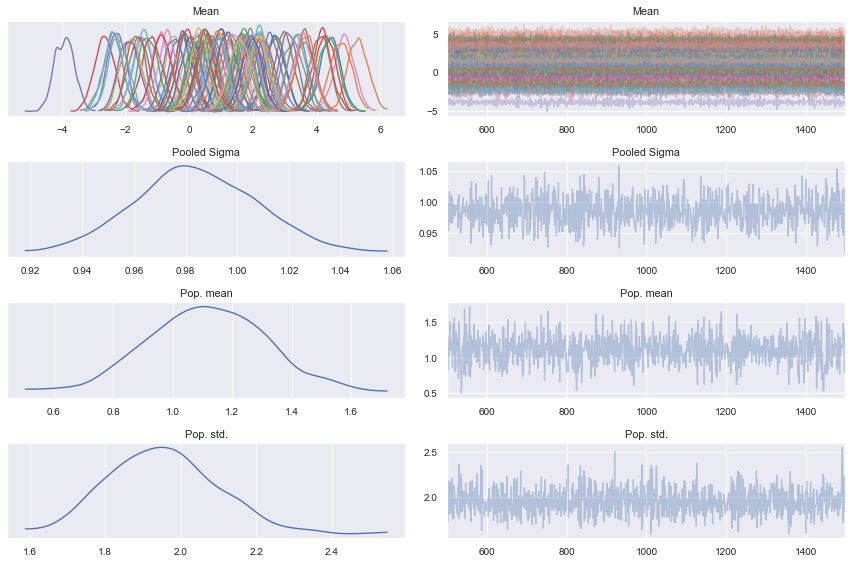

In [168]:
n_ids = 100
log_likelihood = ExactHierarchicalLogLikelihood(observations=data)
log_prior = pints.ComposedLogPrior(*[
    pints.UniformLogPrior(-10, 10)] * n_ids + [
    pints.UniformLogPrior(
        -10 * true_parameters[0],
        10 * true_parameters[0]),
    pints.UniformLogPrior(
        0.01 * true_parameters[1],
        10 * true_parameters[1]),
    pints.GaussianLogPrior(true_parameters[2], 0.1 * true_parameters[2]),
])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller._initial_params = np.array([[[0]*n_ids + [1.3, 2.12, 1]]])
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
posterior_samples = controller.run(n_iterations=n_iterations)

warmup = 500
thinning = 1
az.plot_trace(
    posterior_samples.sel(draw=slice(warmup, n_iterations, thinning)))
plt.tight_layout()

In [169]:
print('True mean :', true_parameters[0])
print('True std. :', true_parameters[1])
print('Data mean :', np.mean(np.mean(data, axis=1)))
print('Data std. :', np.std(np.mean(data, axis=1), ddof=1))

True mean : 1.3
True std. : 2.12
Data mean : 1.1255795319459836
Data std. : 1.9501515051437368


## Run inference with KDE approximation

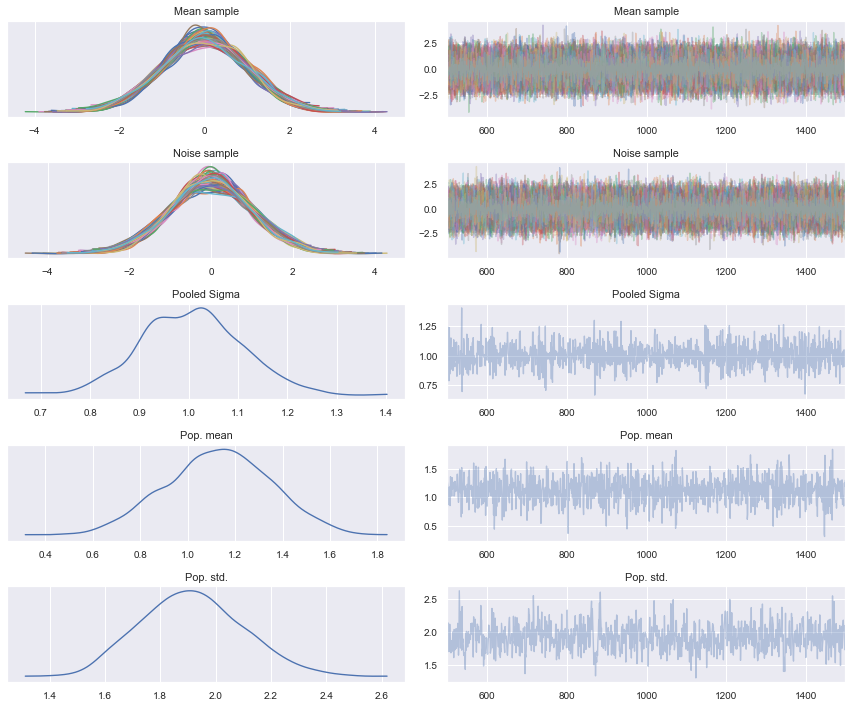

In [151]:
n_samples = 1
n_ids = 100
log_likelihood = GaussianKDELogLikelihood(
    observations=data, n_samples=n_samples, n_ids=n_ids)
n_measurements = n_ids * n_samples
log_prior = pints.ComposedLogPrior(*[
    pints.GaussianLogPrior(0, 1)] * n_ids + [
    pints.GaussianLogPrior(0, 1)] * n_measurements + [
    pints.UniformLogPrior(
        -10 * true_parameters[0],
        10 * true_parameters[0]),
    pints.UniformLogPrior(
        0.01 * true_parameters[0],
        10 * true_parameters[0]),
    pints.GaussianLogPrior(true_parameters[2], 0.1 * true_parameters[2]),
])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
posterior_samples = controller.run(n_iterations=n_iterations)

warmup=500
az.plot_trace(
    posterior_samples.sel(draw=slice(warmup, n_iterations)))
plt.tight_layout()

## Run with 1000 samples

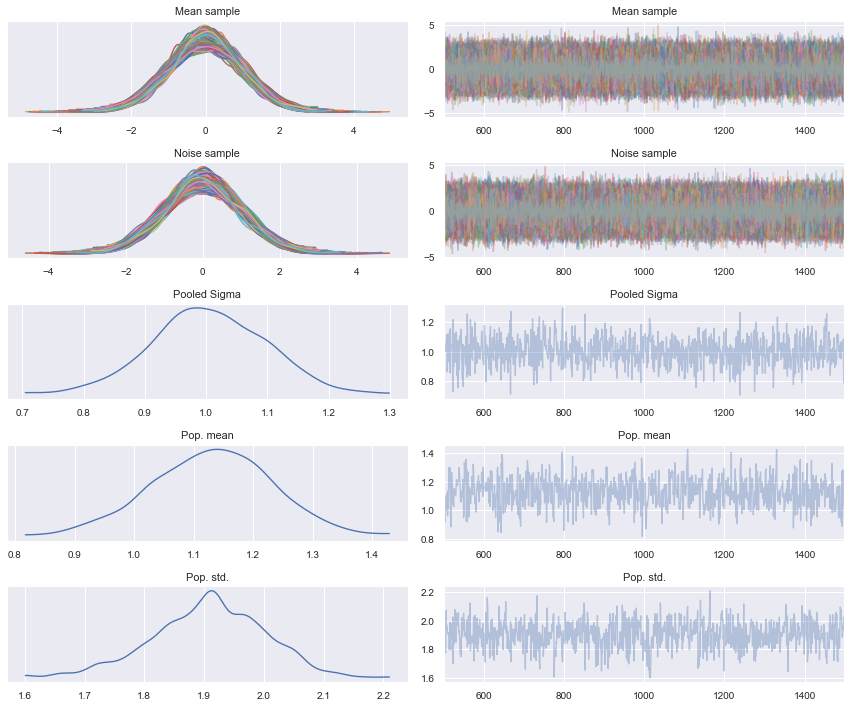

In [170]:
n_samples = 1
n_ids = 1000
log_likelihood = GaussianKDELogLikelihood(
    observations=data, n_samples=n_samples, n_ids=n_ids)
n_measurements = n_ids * n_samples
log_prior = pints.ComposedLogPrior(*[
    pints.GaussianLogPrior(0, 1)] * n_ids + [
    pints.GaussianLogPrior(0, 1)] * n_measurements + [
    pints.UniformLogPrior(
        -10 * true_parameters[0],
        10 * true_parameters[0]),
    pints.UniformLogPrior(
        0.01 * true_parameters[0],
        10 * true_parameters[0]),
    pints.GaussianLogPrior(true_parameters[2], 0.1 * true_parameters[2]),
])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
posterior_samples = controller.run(n_iterations=n_iterations)

warmup=500
az.plot_trace(
    posterior_samples.sel(draw=slice(warmup, n_iterations)))
plt.tight_layout()

# 100 individuals with 1 measurement each

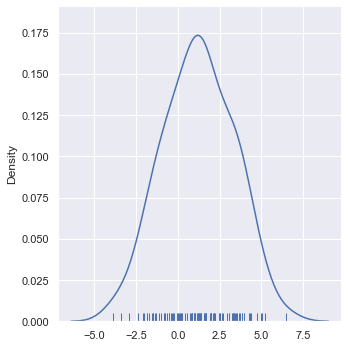

In [171]:
data_small = data[:, 3:4]

sns.displot(data_small.flatten(), kind='kde', rug=True)
plt.show()

## Run inference with exact likelihood

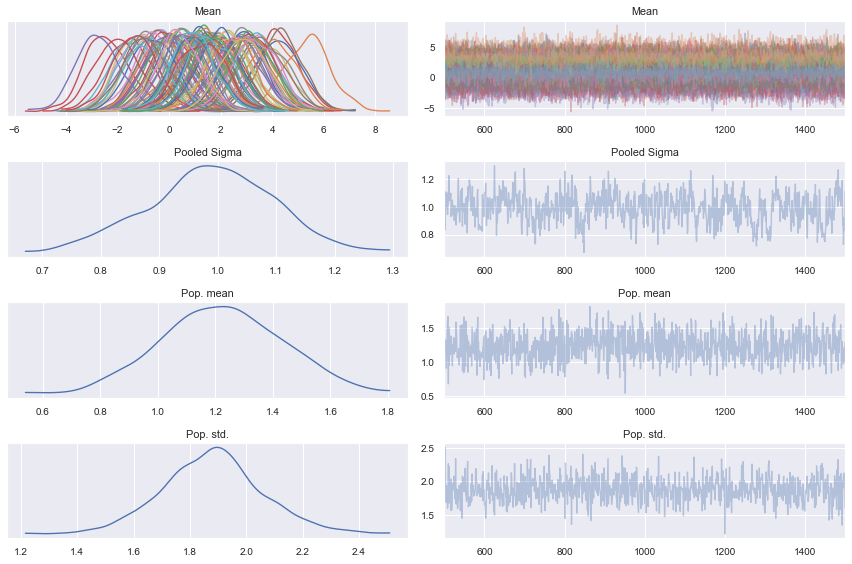

In [173]:
n_ids = 100
log_likelihood = ExactHierarchicalLogLikelihood(observations=data_small)
log_prior = pints.ComposedLogPrior(*[
    pints.UniformLogPrior(-10, 10)] * n_ids + [
    pints.UniformLogPrior(
        -10 * true_parameters[0],
        10 * true_parameters[0]),
    pints.UniformLogPrior(
        0.01 * true_parameters[1],
        10 * true_parameters[1]),
    pints.GaussianLogPrior(true_parameters[2], 0.1 * true_parameters[2]),
])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller._initial_params = np.array([[[0]*n_ids + [1.3, 2.12, 5]]])
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
posterior_samples = controller.run(n_iterations=n_iterations)

warmup = 500
thinning = 1
az.plot_trace(
    posterior_samples.sel(draw=slice(warmup, n_iterations, thinning)))
plt.tight_layout()

In [176]:
print('True mean :', true_parameters[0])
print('True std. :', true_parameters[1])
print('Data mean :', np.mean(data_small))
print('Data std. :', np.std(data_small, ddof=1))

True mean : 1.3
True std. : 2.12
Data mean : 1.227030173242877
Data std. : 2.1018728979275187


## Run inference with Gaussian KDE likelihood

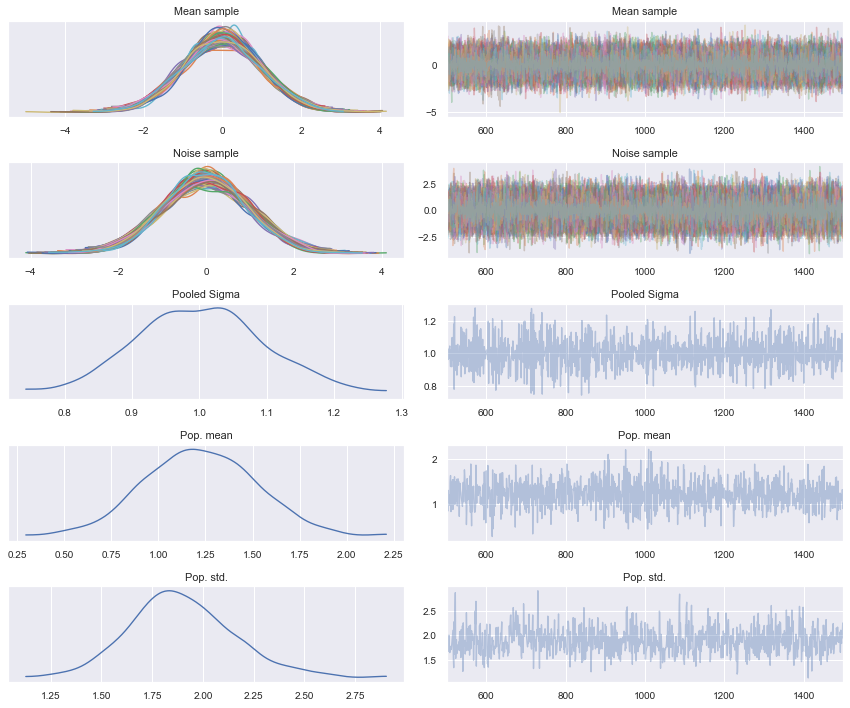

In [174]:
n_samples = 1
n_ids = 100
log_likelihood = GaussianKDELogLikelihood(
    observations=data_small, n_samples=n_samples, n_ids=n_ids)
n_measurements = n_ids * n_samples
log_prior = pints.ComposedLogPrior(*[
    pints.GaussianLogPrior(0, 1)] * n_ids + [
    pints.GaussianLogPrior(0, 1)] * n_measurements + [
    pints.UniformLogPrior(
        -10 * true_parameters[0],
        10 * true_parameters[0]),
    pints.UniformLogPrior(
        0.01 * true_parameters[0],
        10 * true_parameters[0]),
    pints.GaussianLogPrior(true_parameters[2], 0.1 * true_parameters[2]),
])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
posterior_samples = controller.run(n_iterations=n_iterations)

warmup=500
az.plot_trace(
    posterior_samples.sel(draw=slice(warmup, n_iterations)))
plt.tight_layout()

## Run with 1000 samples

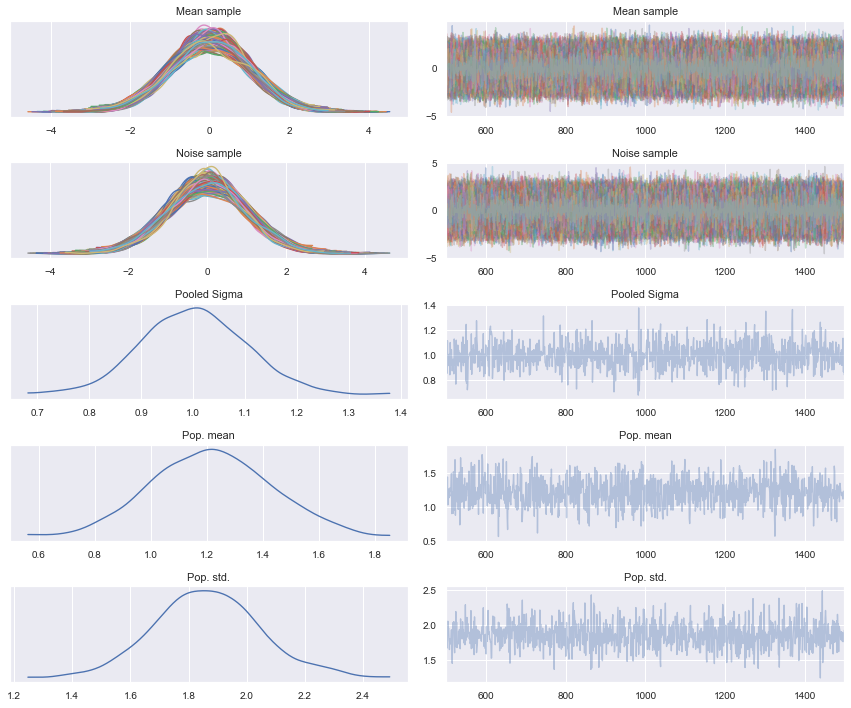

In [175]:
n_samples = 1
n_ids = 1000
log_likelihood = GaussianKDELogLikelihood(
    observations=data_small, n_samples=n_samples, n_ids=n_ids)
n_measurements = n_ids * n_samples
log_prior = pints.ComposedLogPrior(*[
    pints.GaussianLogPrior(0, 1)] * n_ids + [
    pints.GaussianLogPrior(0, 1)] * n_measurements + [
    pints.UniformLogPrior(
        -10 * true_parameters[0],
        10 * true_parameters[0]),
    pints.UniformLogPrior(
        0.01 * true_parameters[0],
        10 * true_parameters[0]),
    pints.GaussianLogPrior(true_parameters[2], 0.1 * true_parameters[2]),
])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
posterior_samples = controller.run(n_iterations=n_iterations)

warmup=500
az.plot_trace(
    posterior_samples.sel(draw=slice(warmup, n_iterations)))
plt.tight_layout()